In [1]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
# Import metrics from scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Set random seed and device
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Define data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
cifar10_full = torchvision.datasets.CIFAR10(root='./datasets', train=True, download=False, transform=transform_train)
train_size = int(0.9 * len(cifar10_full))
val_size = len(cifar10_full) - train_size
cifar10_train, cifar10_val = random_split(cifar10_full, [train_size, val_size])

cifar10_test = torchvision.datasets.CIFAR10(root='./datasets', train=False, download=False, transform=transform_test)

batch_size = 128
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(cifar10_val, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [3]:
# Definition of network model class
class OriginalAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(OriginalAlexNet, self).__init__()
        self.features = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            # add dropout
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # add dropout
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer block 3
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # add dropout
            nn.Dropout(0.3),
            
            # Conv Layer block 4
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # add dropout
            nn.Dropout(0.3),
            
            # Conv Layer block 5
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # add dropout
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # For 32x32 images, the final feature map size is (256, 2, 2) -> flattened size = 256*2*2 = 1024
        self.classifier = nn.Sequential(
            # add dropout
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            # add dropout
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            # add dropout
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

In [4]:
# load model
model = OriginalAlexNet(num_classes=10).to(device)
print(model)

OriginalAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Dropout(p=0.3, inplace=False)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Dropout(p=0.3, inplace=False)
    (17): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    return running_loss / len(dataloader.dataset), correct / total


print("Selected AlexNet parameter count:", count_parameters(model))

Selected AlexNet parameter count: 23272266


In [6]:
num_epochs = 30
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/30: Train Loss: 1.8502, Val Loss: 1.7841, Val Acc: 0.3664
Epoch 2/30: Train Loss: 1.5592, Val Loss: 1.5103, Val Acc: 0.4638
Epoch 3/30: Train Loss: 1.4663, Val Loss: 1.4498, Val Acc: 0.4920
Epoch 4/30: Train Loss: 1.3947, Val Loss: 1.3585, Val Acc: 0.5466
Epoch 5/30: Train Loss: 1.3351, Val Loss: 1.3004, Val Acc: 0.5488
Epoch 6/30: Train Loss: 1.3080, Val Loss: 1.3224, Val Acc: 0.5482
Epoch 7/30: Train Loss: 1.2813, Val Loss: 1.2286, Val Acc: 0.5926
Epoch 8/30: Train Loss: 1.2587, Val Loss: 1.2268, Val Acc: 0.5944
Epoch 9/30: Train Loss: 1.2336, Val Loss: 1.1599, Val Acc: 0.6034
Epoch 10/30: Train Loss: 1.2239, Val Loss: 1.1757, Val Acc: 0.6178
Epoch 11/30: Train Loss: 1.2063, Val Loss: 1.1949, Val Acc: 0.6016
Epoch 12/30: Train Loss: 1.1893, Val Loss: 1.1662, Val Acc: 0.6100
Epoch 13/30: Train Loss: 1.1745, Val Loss: 1.1135, Val Acc: 0.6256
Epoch 14/30: Train Loss: 1.1685, Val Loss: 1.1481, Val Acc: 0.6214
Epoch 15/30: Train Loss: 1.1561, Val Loss: 1.1293, Val Acc: 0.6228
Epoc

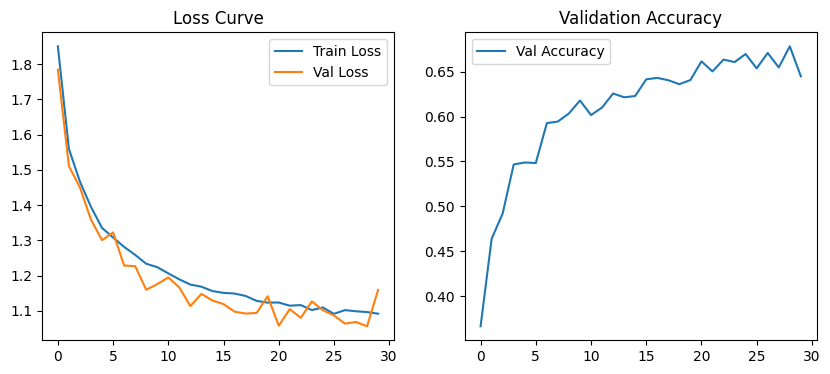

In [7]:
# Save training data and plot the curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title("Validation Accuracy")
plt.savefig("./images/p1_10_dropout_original_alexnet_results.png")
plt.show()

In [8]:
def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)

In [9]:
# Compute predictions on the test set
test_preds, test_targets = compute_metrics(model, test_loader)

# Calculate precision, recall, and F1 score (weighted average)
precision = precision_score(test_targets, test_preds, average="weighted")
recall = recall_score(test_targets, test_preds, average="weighted")
f1 = f1_score(test_targets, test_preds, average="weighted")
conf_matrix = confusion_matrix(test_targets, test_preds)
class_report = classification_report(test_targets, test_preds, target_names=cifar10_test.classes)

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Test Precision: 0.7059442363909733
Test Recall: 0.6716
Test F1 Score: 0.6753060617323007

Confusion Matrix:
 [[699  16  58  13 114   2   4  10  50  34]
 [ 19 798   7  17  14   0  10   9  11 115]
 [ 66   2 435  59 294  51  59  24   4   6]
 [ 13   4  47 444 210 132  94  31   7  18]
 [  8   1  10  33 885  14  15  28   5   1]
 [  7   2  28 253 144 495  18  46   3   4]
 [  3   0  22  68 185   2 709   6   1   4]
 [  7   1  19  39 183  47   4 688   0  12]
 [ 73  37   7  35  45   1   7   3 757  35]
 [ 34  70   2  25  21   1   8  20  13 806]]

Classification Report:
               precision    recall  f1-score   support

    airplane       0.75      0.70      0.72      1000
  automobile       0.86      0.80      0.83      1000
        bird       0.69      0.43      0.53      1000
         cat       0.45      0.44      0.45      1000
        deer       0.42      0.89      0.57      1000
         dog       0.66      0.49      0.57      1000
        frog       0.76      0.71      0.74      1000
  

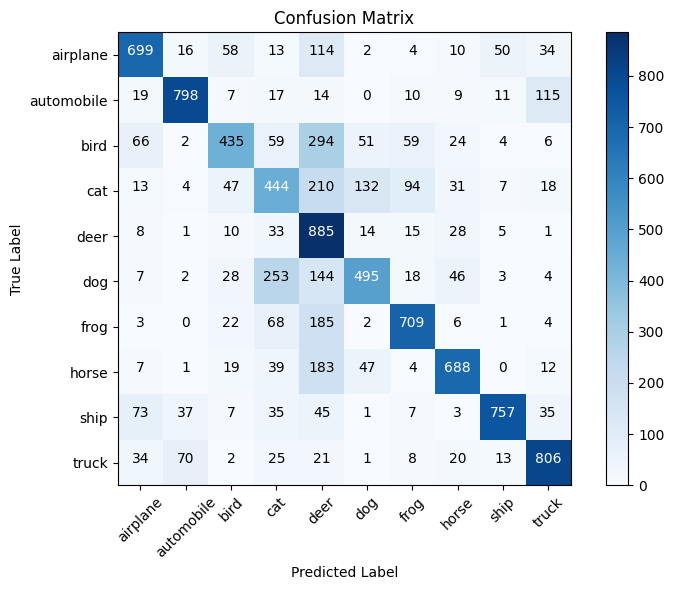

In [10]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(cifar10_test.classes))
plt.xticks(tick_marks, cifar10_test.classes, rotation=45)
plt.yticks(tick_marks, cifar10_test.classes)

# Annotate the confusion matrix cells with the numeric values
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("./images/p1_10_dropout_confusion_matrix.png")
plt.show()